In [14]:
# https://learning.oreilly.com/library/view/machine-learning-with/9781617293870/kindle_split_019.html

from yahoo_finance import Share
import yfinance as yf
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
# for compatibility with TF 1.0
tf.compat.v1.disable_eager_execution()
import random

%matplotlib inline


In [15]:
print(np.__version__)

1.18.5


In [16]:
def get_prices(share_symbol, start_date, end_date, cache_filename='stock_prices.npy'):
#     try:
#         stock_prices = np.load(cache_filename)
#     except IOError:
#         share = Share(share_symbol)
#         stock_hist = share.get_historical(start_date, end_date)
#         stock_prices = [stock_price['Open'] for stock_prices in stock_hist]
        
        
    share = yf.Ticker(share_symbol)
    stock_hist = share.history(start=start_date, end=end_date)
    stock_prices = np.array([stock_price for stock_price in stock_hist['Open']], dtype='float32')
    np.save(cache_filename, stock_prices)

        
    return stock_prices

In [17]:
def plot_prices(prices):
    plt.title('Opening Stock prices')
    plt.xlabel('day')
    plt.ylabel('price ($)')
    plt.plot(prices)
    plt.savefig('prices.png')
    plt.show()

- YHOO: No data found for this date range, symbol may be delisted


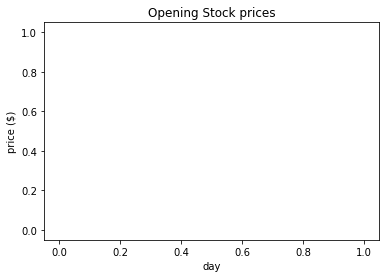

In [18]:
prices = get_prices('YHOO', '1992-07-22', '2020-07-22')
plot_prices(prices)

In [19]:
print(msft.info)

NameError: name 'msft' is not defined

In [7]:
hist = msft.history(period="5d")

NameError: name 'msft' is not defined

In [8]:
msft.history(start='1992-07-22', end='2016-07-22')['Open'].plot(figsize=(16,9))


NameError: name 'msft' is not defined

In [9]:
np.array([stock_price for stock_price in msft.history(start='1992-07-22', end='2016-07-22')['Open']], dtype='float32')

NameError: name 'msft' is not defined

In [10]:
class DecisionPolicy:
    def select_action(self, current_state):
        raise NotImplementedError
    
    def update_q(self, state, action, reward, next_state):
        pass
    

    
class RandomDecisionPolicy(DecisionPolicy):
    def __init__(self, actions):
        self.actions = actions
        
    def select_action(self, current_state, step=0):
        action = random.choice(self.actions)
        return action
    

In [11]:
def run_simulation(policy, initial_budget, initial_num_stocks, prices, hist):
    budget = initial_budget
    num_stocks = initial_num_stocks
    share_value = 0
    transitions = list()
    for i in range(len(prices) - hist - 1):
        if i % 1000 == 0:
            print('progress {:.2f}%'.format(float(100*i) / (len(prices) - hist - 1)))
        current_state = np.asmatrix(np.hstack((prices[i:i+hist], budget, num_stocks)))
        current_portfolio = budget + num_stocks * share_value
        action = policy.select_action(current_state, i)
        share_value = float(prices[i + hist])
        if action == 'Buy' and budget >= share_value:
            budget -= share_value
            num_stocks += 1
        elif action == 'Sell' and num_stocks > 0:
            budget += share_value
            num_stocks -= 1
        else:
            action = 'Hold'
        new_portfolio = budget + num_stocks * share_value
        reward = new_portfolio - current_portfolio
        next_state = np.asmatrix(np.hstack((prices[i+1:i+hist+1], budget, num_stocks)))
        transitions.append((current_state, action, reward, next_state))
        policy.update_q(current_state, action, reward, next_state)
    portfolio = budget + num_stocks * share_value
    return portfolio

        

In [12]:
def run_simulations(policy, budget, num_stocks, prices, hist):
    num_tries = 10
    final_portfolios = list()
    for i in range(num_tries):
        final_portfolio = run_simulation(policy, budget, num_stocks, prices, hist)
        final_portfolios.append(final_portfolio)
        print('Final portfolio: ${}'.format(final_portfolio))
    plt.title('Final Portfolio Value')
    plt.xlabel('Simuation #')
    plt.ylabel('Net Worth')
    plt.plot(final_portfolios)
    plt.show()

In [13]:
stock = 'ADMS'
stock = 'AAPL'
prices = get_prices(stock, '1992-07-22', '2020-07-24')
plot_prices(prices)
actions = ['Buy', 'Sell', 'Hold']
hist = 3
policy = RandomDecisionPolicy(actions)
budget = 100000.0
num_stocks = 0
run_simulations(policy, budget, num_stocks, prices, hist)

ConnectionError: HTTPSConnectionPool(host='query1.finance.yahoo.com', port=443): Max retries exceeded with url: /v8/finance/chart/AAPL?period1=711784800&period2=1595570400&interval=1d&includePrePost=False&events=div%2Csplits (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x00000174DE7BF4C8>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))

In [149]:
class QLearningDecisionPolicy(DecisionPolicy):
    def __init__(self, actions, input_dim):
        self.epsilon = 0.95
        self.gamma = 0.3
        self.actions = actions
        output_dim = len(actions)
        h1_dim = 100
        
        self.x = tf.compat.v1.placeholder(tf.float32, [None, input_dim])
        self.y = tf.compat.v1.placeholder(tf.float32, [output_dim])
        W1 = tf.Variable(tf.compat.v1.random_normal([input_dim, h1_dim]))
        b1 = tf.Variable(tf.constant(0.1, shape=[h1_dim]))
        h1 = tf.nn.relu(tf.matmul(self.x, W1) + b1)
        W2 = tf.Variable(tf.compat.v1.random_normal([h1_dim, output_dim]))
        b2 = tf.Variable(tf.constant(0.1, shape=[output_dim]))
        self.q = tf.nn.relu(tf.matmul(h1, W2) + b2)
        
        loss = tf.square(self.y - self.q)
        self.train_op = tf.compat.v1.train.AdagradOptimizer(0.01).minimize(loss)
        self.sess = tf.compat.v1.Session()
        self.sess.run(tf.compat.v1.global_variables_initializer())
        
    def select_action(self, current_state, step):
        threshold = min(self.epsilon, step / 1000.)
        if random.random() < threshold:
            # exploit best option with probaility epsilon
            action_q_vals = self.sess.run(self.q, feed_dict={self.x: current_state})
            action_idx = np.argmax(action_q_vals)
            action = self.actions[action_idx]
        else:
            # Explore random option iwth probability 1 - epsilon
            action = self.actions[random.randint(0, len(self.actions) - 1)]
        return action
    
    def update_q(self, state, action, reward, next_state):
        action_q_vals = self.sess.run(self.q, feed_dict={self.x: state})
        next_action_q_vals = self.sess.run(self.q, feed_dict={self.x: next_state})
        next_action_idx = np.argmax(next_action_q_vals)
        current_action_idx = self.actions.index(action)
        action_q_vals[0, current_action_idx] = reward + self.gamma * next_action_q_vals[0, next_action_idx]
        action_q_vals = np.squeeze(np.asarray(action_q_vals))
        self.sess.run(self.train_op, feed_dict={self.x: state, self.y: action_q_vals})

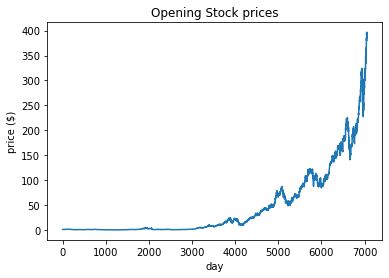

progress 0.00%
progress 14.18%
progress 28.37%
progress 42.55%
progress 56.74%
progress 70.92%
progress 85.11%
progress 99.29%
Final portfolio: $1951849.1449733377
progress 0.00%
progress 14.18%
progress 28.37%
progress 42.55%
progress 56.74%
progress 70.92%
progress 85.11%
progress 99.29%
Final portfolio: $1935944.805279106
progress 0.00%
progress 14.18%
progress 28.37%
progress 42.55%
progress 56.74%
progress 70.92%
progress 85.11%
progress 99.29%
Final portfolio: $1900597.9364914298
progress 0.00%
progress 14.18%
progress 28.37%
progress 42.55%
progress 56.74%
progress 70.92%
progress 85.11%
progress 99.29%
Final portfolio: $1901115.9762185216
progress 0.00%
progress 14.18%
progress 28.37%
progress 42.55%
progress 56.74%
progress 70.92%
progress 85.11%
progress 99.29%
Final portfolio: $1902923.0264508128
progress 0.00%
progress 14.18%
progress 28.37%
progress 42.55%
progress 56.74%
progress 70.92%
progress 85.11%
progress 99.29%
Final portfolio: $1888707.8074020743
progress 0.00%
pr

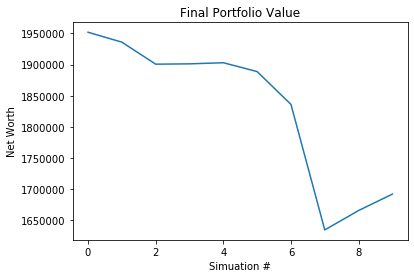

In [150]:
prices = get_prices(stock, '1992-07-22', '2020-07-24')
plot_prices(prices)
actions = ['Buy', 'Sell', 'Hold']
hist = 3
policy = QLearningDecisionPolicy(actions, 5)
budget = 100000.0
num_stocks = 0
run_simulations(policy, budget, num_stocks, prices, hist)

In [151]:
class ConstantPolicy(DecisionPolicy):
    def __init__(self, actions):
        self.actions = actions
        
    def select_action(self, current_state, step=0):
        action = actions[0]
        return action

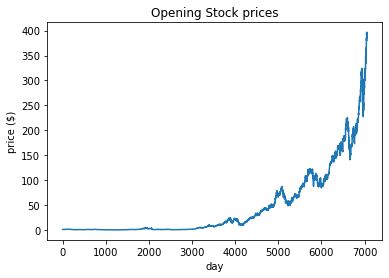

progress 0.00%
progress 14.18%
progress 28.37%
progress 42.55%
progress 56.74%
progress 70.92%
progress 85.11%
progress 99.29%
Final portfolio: $2205772.827313423
progress 0.00%
progress 14.18%
progress 28.37%
progress 42.55%
progress 56.74%
progress 70.92%
progress 85.11%
progress 99.29%
Final portfolio: $2205772.827313423
progress 0.00%
progress 14.18%
progress 28.37%
progress 42.55%
progress 56.74%
progress 70.92%
progress 85.11%
progress 99.29%
Final portfolio: $2205772.827313423
progress 0.00%
progress 14.18%
progress 28.37%
progress 42.55%
progress 56.74%
progress 70.92%
progress 85.11%
progress 99.29%
Final portfolio: $2205772.827313423
progress 0.00%
progress 14.18%
progress 28.37%
progress 42.55%
progress 56.74%
progress 70.92%
progress 85.11%
progress 99.29%
Final portfolio: $2205772.827313423
progress 0.00%
progress 14.18%
progress 28.37%
progress 42.55%
progress 56.74%
progress 70.92%
progress 85.11%
progress 99.29%
Final portfolio: $2205772.827313423
progress 0.00%
progres

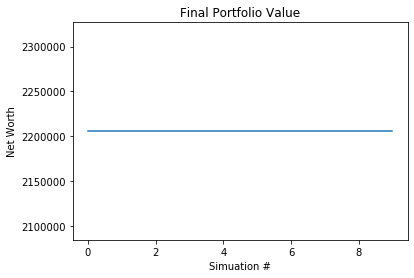

In [152]:
prices = get_prices(stock, '1992-07-22', '2020-07-24')
plot_prices(prices)
actions = ['Buy', 'Sell', 'Hold']
hist = 3
policy = ConstantPolicy(actions)
budget = 100000.0
num_stocks = 0
run_simulations(policy, budget, num_stocks, prices, hist)